<a href="https://colab.research.google.com/github/shubhamk16/Audio-Processing/blob/main/MLSP_kaggle_Audio_Processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [64]:
#============================Import required libraries===========================#

import numpy as np
import pandas as pd
import  pickle
from sklearn.feature_selection import SelectKBest,f_regression
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from sklearn import metrics
from tabulate import tabulate
import plotly.graph_objects as go
import plotly.express as px

In [65]:
#============================ Mount Google drive===========================#

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [66]:
#============================ Change directory to Bird Classification  Data===========================#

import os
PATH  = '/content/drive/My Drive/Competitions/Kaggle_MLSP_Bird_Classification/essential_data'
os.chdir(PATH)


# Data Understanding

Following code represents 19 classes of birds with their respective class_id 

In [67]:
#============================ Load Species Data===========================#

species = pd.read_csv('species_list.txt')
species.to_csv('species_list.csv')
species
header = ['class_id', 'code', 'species']
print(tabulate(species, tablefmt="fancy_grid", headers = header))

╒════╤════════════╤════════╤═══════════════════════════╕
│    │   class_id │ code   │ species                   │
╞════╪════════════╪════════╪═══════════════════════════╡
│  0 │          0 │ BRCR   │ Brown Creeper             │
├────┼────────────┼────────┼───────────────────────────┤
│  1 │          1 │ PAWR   │ Pacific Wren              │
├────┼────────────┼────────┼───────────────────────────┤
│  2 │          2 │ PSFL   │ Pacific-slope Flycatcher  │
├────┼────────────┼────────┼───────────────────────────┤
│  3 │          3 │ RBNU   │ Red-breasted Nuthatch     │
├────┼────────────┼────────┼───────────────────────────┤
│  4 │          4 │ DEJU   │ Dark-eyed Junco           │
├────┼────────────┼────────┼───────────────────────────┤
│  5 │          5 │ OSFL   │ Olive-sided Flycatcher    │
├────┼────────────┼────────┼───────────────────────────┤
│  6 │          6 │ HETH   │ Hermit Thrush             │
├────┼────────────┼────────┼───────────────────────────┤
│  7 │          7 │ CBCH   │ Ch

In [68]:
#============================ Load Bird Classification labels Data===========================#

labels = pd.read_csv("rec_labels_test_hidden.txt", names =['rec_id', 'labels'], skiprows = [0])

labels

,rec_id,labels
0,0,?
1,1,?
2,2,11
3,3,NaN
4,4,?
...,...,...
640,640,8
641,641,4
642,642,4
643,643,?


Total number of NaN items in labels are 143

These NaN items are noise in data which means these are not voices from any birds


Here we know from the data that 0 represents training set, and 1 represents test set.
so from above value counts we know that train data contains 322 values and test set contains 323 examples.

In [20]:
#============================ Load Bird Classification fold Data===========================#

fold_name = pd.read_csv('CVfolds_2.txt')

fold_name

,rec_id,fold
0,0,1
1,1,1
2,2,0
3,3,0
4,4,1
...,...,...
640,640,0
641,641,0
642,642,0
643,643,1


Dataset is split into training and test sets

fold column represents if the example present in test data or train data?

0 is the training set, and 1 is the test set

In [21]:
#============================ Load Bird Classification recording id Data===========================#

rec_id_2_filename = pd.read_csv('rec_id2filename.txt')

rec_id_2_filename

,rec_id,filename
0,0,PC1_20090513_050000_0010
1,1,PC1_20090513_070000_0010
2,2,PC1_20090606_050012_0010
3,3,PC1_20090606_070012_0010
4,4,PC1_20090705_050000_0010
...,...,...
640,640,PC18_20100513_043000_0750
641,641,PC18_20100705_050000_0040
642,642,PC18_20100705_070000_0040
643,643,PC18_20100804_050020_0040


Each audio file has a unique recording identifier ("rec_id"), ranging from 0 to 644. 

The file rec_id2filename.txt indicates which wav file is associated with each rec_id.

WAV also known as (Waveform Audio File Format).

It is an audio file format standard, developed by IBM and Microsoft, for storing audio bitstream.



Lets concate the datafiles that we required for the prediction

In [22]:
#============================ concate recording id, label & fold data together ===========================#

data = pd.concat([rec_id_2_filename,fold_name['fold'],labels['labels']],axis=1)
data

,rec_id,filename,fold,labels
0,0,PC1_20090513_050000_0010,1,?
1,1,PC1_20090513_070000_0010,1,?
2,2,PC1_20090606_050012_0010,0,11
3,3,PC1_20090606_070012_0010,0,NaN
4,4,PC1_20090705_050000_0010,1,?
...,...,...,...,...
640,640,PC18_20100513_043000_0750,0,8
641,641,PC18_20100705_050000_0040,0,4
642,642,PC18_20100705_070000_0040,0,4
643,643,PC18_20100804_050020_0040,1,?


From above file, we see label column has Nan value. Just check if NaN values are present in other columns also.

In [23]:
#============================ Check if any null values are present in data ===========================#

data.isnull().sum()

rec_id        0
filename      0
fold          0
labels      143
dtype: int64

In [24]:
#============================ shape of Data===========================#

print('shape of data file is:',np.shape(data))

shape of data file is: (645, 4)


In [25]:
# creting a seperate class for the nan 143 values in data
# data['labels'] = data['labels'].dropna()#fillna(19)

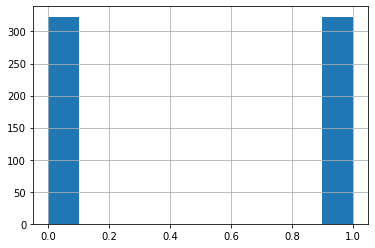

In [26]:
#============================ plot hist of folds===========================#

data.fold.hist()
plt.show()

Lets Divide the data into train and test set according to folds they belong to...

In [27]:
#============================ seperate out two folds ===========================#

train = data[data['fold']==0]

test = data[data['fold']==1]

In [28]:
#============================ load the libraries required for visualization and audio processing ===========================#

import librosa
import librosa.display
import IPython.display as ipd

In [29]:
#============================ plot hist of labels for train data ===========================#

import plotly.graph_objects as go

label_count  = train['labels'].value_counts()
label_count = label_count[:19,]

fig = go.Figure([go.Bar(x=  label_count.index, y= label_count)])

fig.update_layout(
    # title = 'Train data label count',
    xaxis_title='bird classes',
    yaxis_title='value counts',
    width=700, height=400
)

fig.show()


label counts tell us, for each species how many examples we have in train data.

so from above data we see class 1 has 35 examples.
class 10 has 19 examples
and similarlily class 3, 16, 15 has 2 examples only.
and the noise class(i.e. 19 class) has 143 examples(almost 50%). which will lead the model to overfitting. 

we will have to think how to handle that while building model.

In [30]:
path2 = PATH+'/src_wavs/'
os.chdir(path2)

In [31]:
#============================ load one of the audio files ===========================#

num = np.random.randint(300) # it creats a random number between 0 to 300

filename  = data['filename'][num]+'.wav'

dt,sampling_rate = librosa.load(filename) # here we load the audio file

print(len(dt))

220500


This returns an audio time series as a numpy array with a default sampling rate(sr) of 22KHZ.

The sample rate is the number of samples of audio carried per second, measured in Hz or kHz.

In [32]:
sampling_rate
# librosa.load(audio_data, sr=44100) #we can change the sampling rate to the value we wanted by changing the sr = (some number)

22050

# Audio processing

Lets visualize one of the audio files from the data files.

In [33]:
data.iloc[20]

rec_id                            20
filename    PC2_20090705_050000_0010
fold                               0
labels                             7
Name: 20, dtype: object

In [34]:
#============================ function to plot audio example ===========================#
def plot_audio(audio_example_number):
  filename  = data['filename'][audio_example_number]+'.wav'
  dt,sampling_rate = librosa.load(filename)

  plt.figure(figsize = (15,5))

  librosa.display.waveplot(dt,sr = sampling_rate)

  print("Bird category class is:",data["labels"].iloc[audio_example_number])

  return ipd.Audio(filename)

Bird category class is: nan


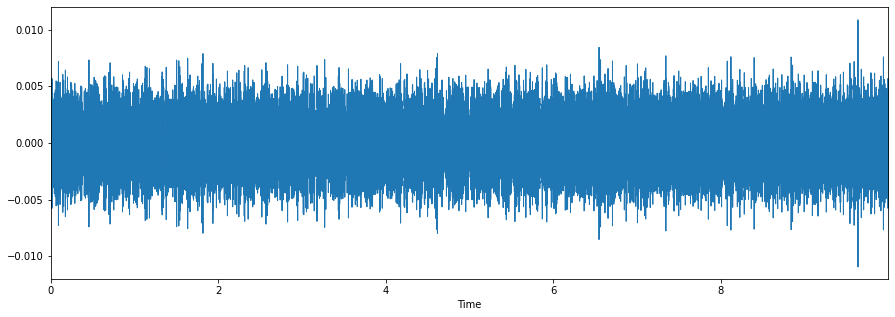

In [35]:
# call the plot_audio function

filename  = data['filename'][3]+'.wav'

plot_audio(3)

In [36]:
data["labels"].iloc[3]

nan

### Spectogram

A spectrogram is a visual way of representing the signal strength, or “loudness”, of a signal over time at various frequencies present in a particular waveform. 

Not only can one see whether there is more or less energy at, for example, 2 Hz vs 10 Hz, but one can also see how energy levels vary over time.

A spectrogram is usually depicted as a heat map, i.e., as an image with the intensity shown by varying the color or brightness

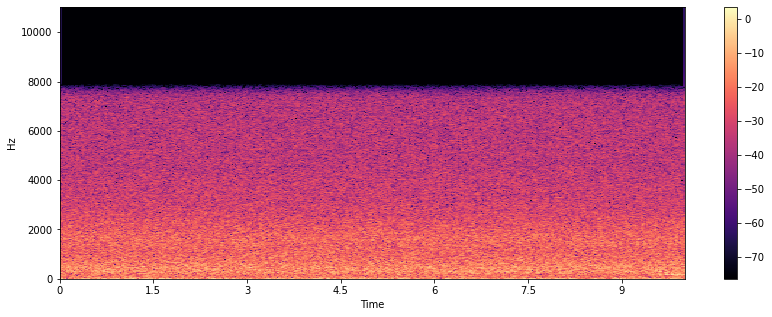

In [37]:
#============================ Spectogram Visualization===========================#

# short term fourier transform

deb_data = librosa.stft(dt) 

Xdb = librosa.amplitude_to_db(abs(deb_data))

plt.figure(figsize=(14, 5))

librosa.display.specshow(Xdb, sr=sampling_rate, x_axis='time', y_axis='hz')

plt.colorbar()
plt.show()

.stft() converts data into short term Fourier transform. 

STFT converts signals such that we can know the amplitude of the given frequency at a given time. 

Using STFT we can determine the amplitude of various frequencies playing at a given time of an audio signal.

The vertical axis shows frequencies (from 0 to 10kHz), and the horizontal axis shows the time of the clip. 


In [38]:
Xdb.shape

(1025, 431)

Since we see that all action is taking place at the bottom of the spectrum, we can convert the frequency axis to a logarithmic one.

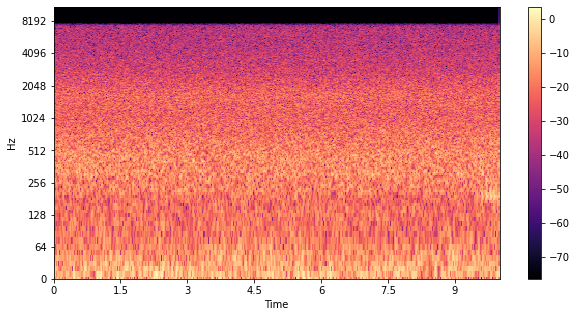

In [39]:
#============================  convert the frequency axis to a logarithmic one  ===========================#

plt.figure(figsize=(10, 5))

librosa.display.specshow(Xdb, sr=sampling_rate, x_axis='time', y_axis='log')

plt.colorbar()
plt.show()

Bird category class is: 6


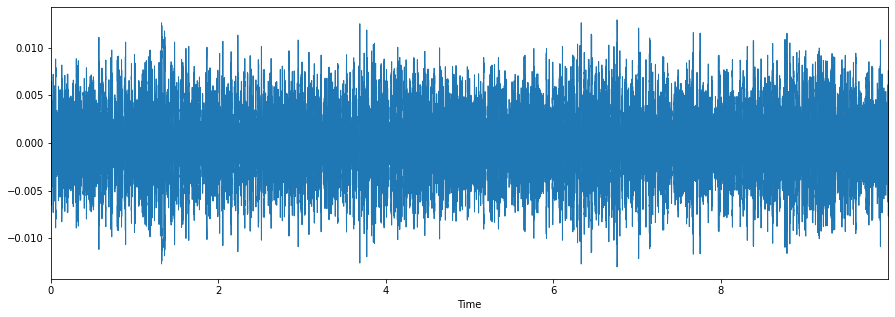

In [40]:
#============================ plot another example ===========================#

filename  = train["filename"][46]+'.wav'

plot_audio(100)

Zero-Crossing Rate

A very simple way for measuring the smoothness of a signal is to calculate the number of zero-crossing within a segment of that signal. A voice signal oscillates slowly". 

for example, a 100 Hz signal will cross zero 100 per second — whereas an unvoiced fricative can have 3000 zero crossings per second.

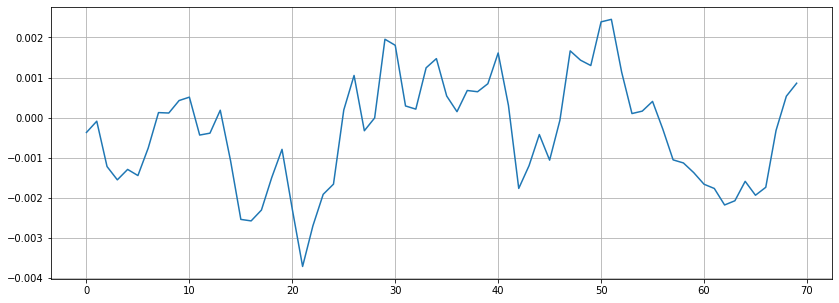

In [41]:
# Zooming in
n0 = 780
n1 = 850
plt.figure(figsize=(14, 5))
plt.plot(dt[n0:n1])
plt.grid()

from our observation there are 2 zero crossings because the blue lines cut the zero axis 2 times,  lets confirm it with librosa zero crossing feature.

In [42]:
zero_crossings = librosa.zero_crossings(dt[n0:n1], pad=False)
print(sum(zero_crossings))

11


### Mel-Frequency Cepstral Coefficients

MFCCs

The Mel frequency cepstral coefficients (MFCCs) of a signal are a small set of features (usually about 10–20) which concisely describe the overall shape of a spectral envelope. 

It models the characteristics of the human voice.

In [43]:
mfccs = librosa.feature.mfcc(dt,sr = sampling_rate)
mfccs.shape
#The first value represents the number of mfccs calculated and another value represents a number of frames available.

(20, 431)

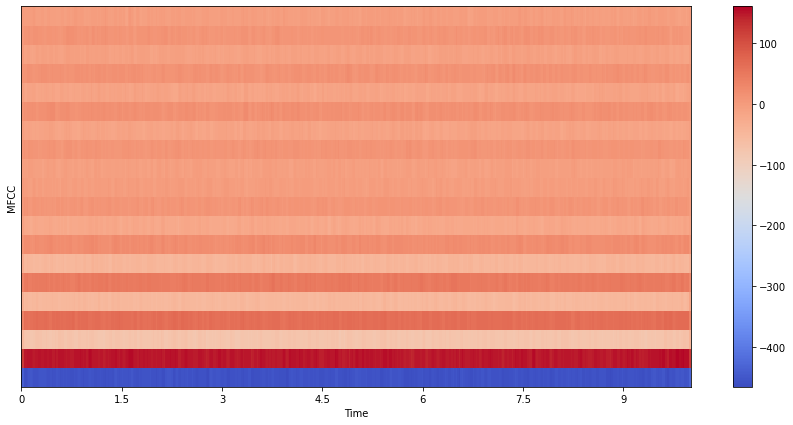

In [44]:
#============================ Displaying the MFCCs ===========================#

plt.figure(figsize=(15, 7))

librosa.display.specshow(mfccs, sr=sampling_rate, x_axis='time')

plt.ylabel('MFCC')

plt.colorbar()
plt.show()

ok. so most of the important features can be found in MFCC only.

so just like we did in above example. now we do the same exercise in loop.

so that for each example in data we will extract the features with help of MFCC and stored in variable feature_df.

In [45]:
#============================ extract the features with help of MFCC and stored in variable feature_df ===========================#

feature_df = pd.DataFrame(columns = ['feature'])
counter = 0

for index,path in enumerate(data.filename):

    X, sample_rate = librosa.load(path+'.wav',duration=10,sr=16000) # res_type='kaiser_fast', ,offset=0.5
    
    sample_rate = np.array(sample_rate)
    
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc= 13),axis=0)
    
    feature_df.loc[counter] = [mfccs]
    
    counter=counter+1 

length of features df is same as length of data which is 645

 The features looks like below

In [46]:
feature_df.head()

,feature
0,"[-18.45621323574996, -17.403274431431388, -17...."
1,"[-20.875614947986914, -20.270696870663514, -18..."
2,"[-24.76340735165977, -24.82535089324621, -25.0..."
3,"[-24.570437031891288, -25.57310848907178, -26...."
4,"[-26.374019598064134, -26.533945452143936, -27..."


Lets concat the data file with the newly created features file

In [47]:
#============================ concate the data ===========================#

main_df = pd.concat([data,pd.DataFrame(feature_df["feature"].values.tolist())],axis=1)
main_df.head()

,rec_id,filename,fold,labels,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,...,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312
0,0,PC1_20090513_050000_0010,1,?,-18.456213,-17.403274,-17.247697,-18.864218,-19.585820,-17.468374,-16.629212,-17.523030,-17.722337,-17.371555,-17.009935,-17.176018,-17.885726,-18.398006,-19.609844,-17.048380,-16.897829,-16.800156,-15.541124,-17.053523,-17.271648,-17.137177,-18.425692,-17.304800,-16.604138,-16.880321,-16.729993,-17.608160,-17.831029,-15.908730,-15.356709,-18.356309,-18.661860,-18.389527,-18.558925,-17.558936,...,-19.495992,-18.926809,-17.667108,-17.919489,-18.889804,-21.180059,-20.599619,-19.811695,-18.476667,-18.757670,-18.544217,-18.356580,-19.239721,-19.710345,-17.844026,-17.482883,-19.831213,-18.965917,-18.617559,-19.946499,-19.666733,-17.954023,-17.935750,-19.838466,-19.761289,-18.946798,-20.192135,-19.195671,-19.464064,-20.048029,-18.819150,-16.805391,-16.614637,-18.348949,-18.451071,-18.682125,-19.653753,-20.410722,-20.744268,-22.471294
1,1,PC1_20090513_070000_0010,1,?,-20.875615,-20.270697,-18.542199,-17.342837,-17.266715,-17.525985,-17.874696,-19.289998,-17.760527,-18.098194,-18.858574,-18.859100,-20.942154,-22.346491,-19.492260,-17.942507,-18.981946,-21.410104,-19.150452,-17.848594,-18.947638,-19.658327,-19.533044,-20.093426,-20.227187,-18.947498,-19.592911,-19.872418,-19.133563,-20.100551,-20.405463,-19.822027,-19.337797,-19.088364,-18.980515,-19.790506,...,-18.973925,-17.501406,-18.741505,-19.570597,-20.981826,-21.570330,-19.610718,-20.824954,-19.447971,-17.424211,-17.700646,-19.051282,-20.893240,-20.306958,-19.119238,-19.355497,-19.775760,-19.374552,-18.554511,-18.629065,-20.384193,-19.691942,-17.967750,-18.529576,-18.565214,-18.459680,-18.613896,-17.668828,-19.045454,-19.656378,-20.000559,-20.066277,-20.031055,-20.193711,-18.917081,-19.830568,-21.285569,-20.624381,-19.320607,-20.768419
2,2,PC1_20090606_050012_0010,0,11,-24.763407,-24.825351,-25.066154,-24.928865,-24.780008,-24.356421,-25.112122,-24.822778,-25.097548,-26.817223,-25.097673,-23.919838,-23.064840,-23.373543,-23.621543,-24.573799,-23.502773,-22.837674,-24.736630,-23.453733,-23.125173,-24.211103,-25.245582,-25.002574,-24.440842,-24.879447,-25.251430,-23.886579,-24.441558,-25.285598,-25.982446,-25.365601,-24.915678,-25.447925,-24.647794,-24.058087,...,-24.693635,-24.746063,-24.287963,-23.981511,-24.314177,-24.056092,-24.539635,-26.106255,-25.674842,-24.772440,-25.454168,-25.208449,-24.719341,-26.503933,-26.443198,-25.347989,-26.194149,-24.391833,-24.657404,-24.872391,-25.014982,-24.617061,-24.350547,-24.939030,-24.514376,-25.024088,-24.981033,-25.433953,-25.897915,-24.402684,-23.502700,-23.830858,-23.076329,-23.827337,-23.881637,-25.291136,-24.533962,-23.901550,-24.538475,-25.354705
3,3,PC1_20090606_070012_0010,0,NaN,-24.570437,-25.573108,-26.683177,-26.488966,-26.379582,-25.387195,-24.728747,-25.490063,-26.243459,-27.300623,-26.903625,-25.767945,-26.273503,-24.902110,-23.323124,-24.398972,-25.001919,-25.507916,-26.146709,-25.869155,-25.611414,-25.859449,-24.573699,-24.703673,-25.895574,-25.413209,-26.339485,-28.704781,-27.203772,-26.062065,-26.504746,-26.696858,-26.894529,-25.027160,-26.300865,-25.289058,...,-24.628459,-25.695168,-25.455166,-25.376853,-26.178404,-26.165483,-25.385705,-24.721512,-25.761704,-25.634428,-25.481212,-26.042412,-25.350722,-25.378145,-25.906933,-26.194003,-25.938055,-26.047158,-25.720866,-24.932382,-26.062588,-26.443271,-26.168940,-27.466630,-27.469422,-26.515252,-25.204426,-24.483340,-25.219343,-26.792202,-27.759040,-25.379651,-24.114898,-24.878416,-24.727299,-26.064264,-26.779647,-25.915200,-24.845212,-24.394341
4,4,PC1_20090705_050000_0010,1,?,-26.374020,-26.533945,-27.146746,-28.353121,-28.156392,-27.671135,-27.439357,-27.740852,-28.062002,-27.705574,-26.013142,-25.812251,-25.644603,-25.778545,-25.789484,-27.513592,-27.9

Lets seperate out the train and test data with fold name as we did it before

In [48]:
train = main_df[main_df['fold']==0]
train = train.dropna()

test = main_df[main_df['fold']==1]
test = test.dropna()

Now lets save the labels column in new variable y. It is general procedure in machine learning to remove the target variable from the dataset.

In [49]:
y = train.labels
y =  y.astype('int')

Lets remove the unwanted columns from the data file

In [50]:
# here we drop unwanted column such as labels, fold, rec_id
X = train.drop(["labels","fold","filename",'rec_id'],axis=1)

In [51]:
X.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312
2,-24.763407,-24.825351,-25.066154,-24.928865,-24.780008,-24.356421,-25.112122,-24.822778,-25.097548,-26.817223,-25.097673,-23.919838,-23.064840,-23.373543,-23.621543,-24.573799,-23.502773,-22.837674,-24.736630,-23.453733,-23.125173,-24.211103,-25.245582,-25.002574,-24.440842,-24.879447,-25.251430,-23.886579,-24.441558,-25.285598,-25.982446,-25.365601,-24.915678,-25.447925,-24.647794,-24.058087,-23.766111,-23.805243,-23.596214,-23.527349,...,-24.693635,-24.746063,-24.287963,-23.981511,-24.314177,-24.056092,-24.539635,-26.106255,-25.674842,-24.772440,-25.454168,-25.208449,-24.719341,-26.503933,-26.443198,-25.347989,-26.194149,-24.391833,-24.657404,-24.872391,-25.014982,-24.617061,-24.350547,-24.939030,-24.514376,-25.024088,-24.981033,-25.433953,-25.897915,-24.402684,-23.502700,-23.830858,-23.076329,-23.827337,-23.881637,-25.291136,-24.533962,-23.901550,-24.538475,-25.354705
5,-29.070497,-27.964099,-28.416335,-29.569405,-27.134309,-28.500561,-28.324817,-26.213099,-25.659808,-25.719900,-27.673640,-27.548703,-27.103102,-26.887253,-25.901155,-27.102285,-27.880864,-26.785548,-27.448652,-26.328007,-27.927214,-28.363952,-26.677392,-26.242011,-27.096198,-28.431015,-28.055365,-27.140569,-27.499731,-27.317969,-26.535035,-27.296527,-27.268444,-27.114647,-26.326039,-27.210020,-26.061215,-25.657797,-27.854125,-27.777130,...,-25.094188,-25.017634,-24.947661,-27.073748,-28.861788,-28.881289,-29.303291,-29.306313,-27.649911,-26.160311,-25.456690,-27.062603,-28.255556,-27.277227,-25.414855,-27.255352,-28.711511,-26.527157,-26.619126,-25.612299,-25.843195,-28.944817,-26.680262,-25.939941,-27.638561,-27.783767,-27.235265,-27.031700,-26.744199,-28.316330,-28.368762,-26.492251,-26.100317,-25.685424,-26.198180,-27.475315,-25.198052,-25.773255,-27.576878,-26.617219
13,-27.627753,-25.935200,-23.318236,-25.075412,-26.146638,-25.362856,-26.527902,-25.158546,-25.340786,-26.641567,-26.483332,-27.206347,-25.428827,-24.390816,-24.902269,-25.954813,-26.176728,-25.859173,-24.412441,-24.609456,-24.024139,-23.998301,-26.118793,-25.676610,-24.683157,-25.484769,-25.249277,-26.239033,-26.406388,-26.700284,-26.694524,-25.563624,-24.565208,-24.846012,-25.508077,-25.327454,-24.295008,-25.224051,-25.114921,-24.986768,...,-25.840808,-25.579797,-24.361834,-23.944636,-24.193305,-24.804257,-24.343824,-25.328070,-26.923889,-26.890354,-26.644158,-25.279219,-24.017391,-23.545030,-24.012907,-25.763818,-25.620330,-23.489163,-25.319877,-26.847452,-24.325413,-24.365481,-25.734323,-26.506793,-26.411774,-25.904324,-26.088964,-25.864497,-25.576219,-24.701929,-25.017344,-25.671468,-25.966988,-25.570510,-25.093420,-25.345233,-24.422097,-24.168310,-23.817362,-24.704822
18,-20.919520,-21.836070,-22.576782,-22.935998,-22.369488,-22.942525,-22.424858,-21.695886,-20.813163,-22.261915,-23.399830,-22.326090,-22.382944,-24.588978,-23.935828,-22.002250,-22.911785,-21.402418,-20.973429,-22.631463,-23.991373,-23.595846,-23.002566,-22.721937,-23.759283,-22.011606,-22.071615,-22.511876,-21.888481,-21.812159,-22.493216,-22.182171,-22.259861,-21.851622,-21.211489,-21.858583,-21.986011,-23.180428,-22.836128,-21.393618,...,-19.221187,-19.080965,-18.371555,-17.924628,-18.613996,-17.560068,-15.835210,-16.228813,-17.479039,-17.321358,-18.545645,-19.662207,-18.173861,-16.918966,-16.983004,-17.164636,-17.196444,-16.090575,-16.093811,-18.033787,-17.509793,-17.171196,-16.066174,-15.935083,-17.313769,-16.314422,-15.481739,-14.497458,-15.599212,-16.367979,-14.826841,-14.621478,-15.190938,-14.486915,-16.446561,-16.865787,-15.616650,-15.595021,-15.322788,-13.739766
19,-25.354842,-24.080259,-23.658113,-23.990265,-25.175192,-25.657132,-26.090973,-25.216395,-23.694444,-23.596783,-24.560732,-25.628454,-24.171893,-24.381810,-24.802817,-24.582943,

In [52]:
main_df2 = main_df.copy()

To avoid overfitting, we will balanced the class distribution by using OversamplingTechniques like SMOTE

## SMOTE: Synthetic Minority Over-sampling Technique

SMOTE is a technique based on nearest neighbors judged by Euclidean Distance between data points in feature space.


SMOTE (synthetic minority oversampling technique) is one of the most commonly used oversampling methods to solve the imbalance problem.
It aims to balance class distribution by randomly increasing minority class examples by replicating them.

SMOTE synthesises new minority instances between existing minority instances. It generates the virtual training records by linear interpolation for the minority class. These synthetic training records are generated by randomly selecting one or more of the k-nearest neighbors for each example in the minority class. After the oversampling process, the data is reconstructed and several classification models can be applied for the processed data.

In [53]:
#============================ Data Oversampling ===========================#

import warnings

warnings.filterwarnings("ignore")

from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=0)

X_resampled, y_resampled = ros.fit_resample(X, y)

Now from the train data to build a machine learning model we should convert the train data into train and validation split

so here we use 85% data as train data on which we build our model.  

and on remaining 15% data which is validation data. we will cross check our model( as it performs well or not).

## Train Test Split

In [54]:
#============================ split the data in train, test ===========================#

from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X_resampled, y_resampled,stratify=y_resampled , test_size=0.15,random_state=42)

# Performance Measure

## AUC_ROC

In [55]:
#============================ function for AUC-ROC data ===========================#

from sklearn.metrics import roc_auc_score

from sklearn.preprocessing import LabelBinarizer

def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)
    return roc_auc_score(y_test, y_pred, average=average)

Now we are using a various classifiers to classify our bird classes.

# Plot AUC ROC Curve

In [56]:
from sklearn.metrics import roc_curve, auc

def plot_auc(model):

  model.fit(X_train, y_train)
  y_scores = model.predict_proba(X_test)

  # One hot encode the labels in order to plot them
  y_onehot = pd.get_dummies(y_test, columns=model.classes_)

  # Create an empty figure, and iteratively add new lines
  # every time we compute a new class
  fig = go.Figure()
  fig.add_shape(
      type='line', line=dict(dash='dash'),
      x0=0, x1=1, y0=0, y1=1
  )

  for i in range(y_scores.shape[1]):
      y_true = y_onehot.iloc[:, i]
      y_score = y_scores[:, i]

      fpr, tpr, _ = roc_curve(y_true, y_score)
      auc_score = roc_auc_score(y_true, y_score)

      name = f"{y_onehot.columns[i]} (AUC={auc_score:.2f})"
      fig.add_trace(go.Scatter(x=fpr, y=tpr, name=name, mode='lines'))

  fig.update_layout(
      # title = 'Multiclasss AUC',
      xaxis_title='False Positive Rate',
      yaxis_title='True Positive Rate',
      yaxis=dict(scaleanchor="x", scaleratio=1),
      xaxis=dict(constrain='domain'),
      width=700, height=500
  )
  fig.show()

# Model Implementation

In [57]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB 
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import lightgbm as lgb

# 1) KNN

In [58]:
#============================ KNN classifier ===========================#

def Knn_Classifier (X_train, y_train):
  knn = KNeighborsClassifier(n_neighbors = 3)
  knn.fit(X_train, y_train) 
  knn_pred= knn.predict(X_test)
  print("\nAccuracy for KNN classifier:",metrics.accuracy_score(y_test, knn_pred))
  print("AUC_ROC for KNN classifier:",multiclass_roc_auc_score(y_test,knn_pred))

Knn_Classifier (X_train, y_train)


Accuracy for KNN classifier: 0.78
AUC_ROC for KNN classifier: 0.8860051865385749


In [ ]:
model = KNeighborsClassifier(n_neighbors = 3)
plot_auc(model)

# 2) Logistic Regression

In [ ]:
def logistic_regression_classifier(X_train,y_train):
  logistic= LogisticRegression(multi_class='multinomial')
  logistic.fit(X_train,y_train)
  logistic_pred= logistic.predict(X_test)
  print("\nAccuracy for logistic  regression:",metrics.accuracy_score(y_test, logistic_pred))
  print("AUC_ROC for logistic regression:",multiclass_roc_auc_score(y_test,logistic_pred))

logistic_regression_classifier(X_train,y_train)


Accuracy for logistic  regression: 0.85
AUC_ROC for logistic regression: 0.9221488772322743


In [ ]:
model =  LogisticRegression(multi_class='multinomial')
plot_auc(model)

# 3) Naive Bayes

In [ ]:
def naive_bayes_classifier(X_train, y_train) :
  gnb = GaussianNB().fit(X_train, y_train) 
  gnb_predictions = gnb.predict(X_test) 
  print("\nAccuracy for Naive bayes:",metrics.accuracy_score(y_test, gnb_predictions))
  print("AUC_ROC for naive bayes:",multiclass_roc_auc_score(y_test,gnb_predictions))

naive_bayes_classifier(X_train, y_train)


Accuracy for Naive bayes: 0.44
AUC_ROC for naive bayes: 0.7081717451523545


In [ ]:
model =  GaussianNB().fit(X_train, y_train) 
plot_auc(model)

# 4) SVM

In [ ]:
def SVM_classifier(X_train, y_train):
  svm_model_linear = SVC(kernel = 'linear', C = 3).fit(X_train, y_train)
  svm_predictions = svm_model_linear.predict(X_test)
  print("\nAccuracy for SVM:",metrics.accuracy_score(y_test, svm_predictions))
  print("AUC_ROC for SVM:",multiclass_roc_auc_score(y_test,svm_predictions))

SVM_classifier(X_train, y_train)


Accuracy for SVM: 0.85
AUC_ROC for SVM: 0.9221459303353569


In [ ]:
model =  SVC(kernel = 'linear', C = 3 ,  probability=True)
plot_auc(model)

# 5) Random Forest

In [ ]:
def random_forest_classsifier(X_train,y_train):
  RF = RandomForestClassifier(random_state = 41)
  RF.fit(X_train,y_train)
  pred= RF.predict(X_test)
  pred_prob = RF.predict_proba(X_test)
  # lets print the accuracy for our validation set.
  print("\nAccuracy for RandomForestClassifier:",metrics.accuracy_score(y_test, pred))
  print("AUC_ROC for RandomForestClassifier:",multiclass_roc_auc_score(y_test,pred))

random_forest_classsifier(X_train,y_train)


Accuracy for RandomForestClassifier: 0.87
AUC_ROC for RandomForestClassifier: 0.9341093495216203


In [ ]:
model =  RandomForestClassifier(random_state = 41)
plot_auc(model)

## 6) Gradient boosting classifier

In [ ]:
def grad_boost_classifier(X_train,y_train):
  gb = GradientBoostingClassifier(max_depth= 4)
  gb.fit(X_train,y_train)
  pred= gb.predict(X_test)
  print("\nAccuracy for GradientBoostingClassifier:",metrics.accuracy_score(y_test, pred))
  print("AUC_ROC for GradientBoostingClassifier:",multiclass_roc_auc_score(y_test,pred))

grad_boost_classifier(X_train,y_train)


Accuracy for GradientBoostingClassifier: 0.88
AUC_ROC for GradientBoostingClassifier: 0.9396495157266066


In [ ]:
model =  GradientBoostingClassifier(max_depth= 4)
plot_auc(model)

### 7) Lightgbm

In [ ]:
def lightgbm_classifier(X_train , y_train):
  clf = lgb.LGBMClassifier()
  clf.fit(X_train, y_train)
  pred= clf.predict(X_test)
  print("\nAccuracy for LightgbmClassifier:",metrics.accuracy_score(y_test, pred))
  print("AUC_ROC for LightgbmClassifier:",multiclass_roc_auc_score(y_test,pred))

lightgbm_classifier(X_train , y_train)


Accuracy for LightgbmClassifier: 0.85
AUC_ROC for LightgbmClassifier: 0.9230349109054832


In [ ]:
model =  lgb.LGBMClassifier()
plot_auc(model)

## Data transformation
* Normalization or
* Standardization

In [ ]:
#============================ scale the data to improve performance of some machine learning models ===========================#

from sklearn import preprocessing

X_train = preprocessing.scale(X_train)

X_test = preprocessing.scale(X_test)

In [ ]:
#============================ try all the above examples to see if we can improve the performance ===========================#

Knn_Classifier (X_train, y_train)

logistic_regression_classifier(X_train,y_train)

naive_bayes_classifier(X_train, y_train)

SVM_classifier(X_train, y_train)

random_forest_classsifier(X_train,y_train)

grad_boost_classifier(X_train,y_train)

lightgbm_classifier(X_train , y_train)


Accuracy for KNN classifier: 0.82
AUC_ROC for KNN classifier: 0.9064085184966897

Accuracy for logistic  regression: 0.87
AUC_ROC for logistic regression: 0.932349069762873

Accuracy for Naive bayes: 0.2
AUC_ROC for naive bayes: 0.5804709141274238

Accuracy for SVM: 0.85
AUC_ROC for SVM: 0.9221459303353569

Accuracy for RandomForestClassifier: 0.84
AUC_ROC for RandomForestClassifier: 0.917488850906662

Accuracy for GradientBoostingClassifier: 0.57
AUC_ROC for GradientBoostingClassifier: 0.7696351741616079

Accuracy for LightgbmClassifier: 0.72
AUC_ROC for LightgbmClassifier: 0.8553692461837685


From above results we can see that Random Forest has better AUC_ROC score and Accuracy.

so we will select Random Forest for hyper parameter optimization...


# Hyper parameter Optimization

### Random Search CV

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 50, num = 10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2,3, 5]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()

# Random search of parameters, using 5 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  9.1min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [ ]:
# It will give us best parameters according to Random search CV
rf_random.best_params_

{'bootstrap': False,
 'max_depth': 40,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 900}

In [ ]:
from sklearn.ensemble import RandomForestClassifier
# RF = RandomForestClassifier(random_state= 41 ,n_estimators= 200,
#  min_samples_split = 3,
#  min_samples_leaf = 1,
#  max_features= 'auto',
#  max_depth = 24,
#  bootstrap = False)

RF = RandomForestClassifier(random_state= 41 ,n_estimators= 1000,
 min_samples_split = 2,
 min_samples_leaf = 2,
 max_features= 'auto',
 max_depth = 20,
 bootstrap = False)

RF.fit(X_train,y_train)

pred= RF.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, pred))
print("AUC_ROC:",multiclass_roc_auc_score(y_test,pred))

Accuracy: 0.83
AUC_ROC: 0.9119545784955108


# Feature selection

In [ ]:
# Create a selector object that will use the random forest classifier to identify
# features that have an importance of more than 0.003
gb = GradientBoostingClassifier()
from sklearn.feature_selection import SelectFromModel
# RF1 = SelectFromModel(RF, threshold= 0.003) 
RF1 = SelectFromModel(RF, threshold= 0.003) 

# Train the selector
RF1.fit(X_train, y_train)

SelectFromModel(estimator=RandomForestClassifier(bootstrap=False, ccp_alpha=0.0,
                                                 class_weight=None,
                                                 criterion='gini', max_depth=20,
                                                 max_features='auto',
                                                 max_leaf_nodes=None,
                                                 max_samples=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=2,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=1000, n_jobs=None,
                                                 oob_score=False,
                                                

In [ ]:
X_important_train = RF1.transform(X_train)
X_important_test = RF1.transform(X_test)

In [ ]:
X_important_train.shape, y_train.shape

((565, 152), (565,))

In [ ]:
# RF with less number of features #
RF_feature_selection = RandomForestClassifier(random_state= 41 ,n_estimators= 1000,
 min_samples_split = 5,
 min_samples_leaf = 3,
 max_features= 'auto',
 max_depth = 28,
 bootstrap = False)

RF_feature_selection.fit(X_important_train ,y_train)
pred = RF_feature_selection.predict(X_important_test)

print("Accuracy:",metrics.accuracy_score(y_test, pred))
print("AUC_ROC:",multiclass_roc_auc_score(y_test,pred))

Accuracy: 0.82
AUC_ROC: 0.9072827645822281


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
# Use the random grid to search for best hyperparameters
# First create the base model to tune
RF_imp = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
RF_imp = RandomizedSearchCV(estimator = RF_imp, param_distributions = random_grid, n_iter = 500, cv = 5, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
RF_imp.fit(X_important_train, y_train)


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   59.1s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:  9.2min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed: 16.5min
[Parallel(n_jobs=-1)]: Done 1009 tasks      | elapsed: 25.9min
[Parallel(n_jobs=-1)]: Done 1454 tasks      | elapsed: 36.4min
[Parallel(n_jobs=-1)]: Done 1981 tasks      | elapsed: 49.2min
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed: 62.6min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [ ]:
RF_imp.best_params_


{'bootstrap': False,
 'max_depth': 45,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 400}

In [ ]:
# Create a new random forest classifier for the most important features
clf_important = RandomForestClassifier(bootstrap= False, random_state=41 ,
 max_depth= 25,
max_features= 'auto',
 min_samples_leaf= 1,
min_samples_split= 5,
 n_estimators= 400)

# #n_estimators=800, random_state=41, n_jobs=-1, min_samples_split = 3,
#  min_samples_leaf = 1,
#  max_features= 'auto',
#  max_depth = None,
#  bootstrap = False

# Train the new classifier on the new dataset containing the most important features
clf_important.fit(X_important_train, y_train)

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=25, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=None, oob_score=False, random_state=41, verbose=0,
                       warm_start=False)

In [ ]:
model =  RandomForestClassifier(n_estimators=800, random_state=41, n_jobs=-1, min_samples_split = 3,
 min_samples_leaf = 1,
 max_features= 'auto',
 max_depth = None,
 bootstrap = False)
plot_auc(model)

In [ ]:
from sklearn.metrics import accuracy_score

# Apply The Full Featured Classifier To The Test Data
y_important_pred = clf_important.predict(X_important_test)

# View The Accuracy Of Our Limited Feature (2 Features) Model
# accuracy_score(y_test, y_important_pred)

print("Accuracy:",metrics.accuracy_score(y_test, y_important_pred))
print("AUC_ROC:",multiclass_roc_auc_score(y_test, y_important_pred))

Accuracy: 0.87
AUC_ROC: 0.9332292096422468


As we can see above we are getting same AUC_ROC curve but with less number of features.  which is good things as our model became computationally inexpensive and Robust as well...

In [ ]:
print("To get same accuracy we are using only",X_important_train.shape[1])

To get same accuracy we are using only 152


# Classification Report

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix
# print(confusion_matrix(y_test,pred))
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.83      1.00      0.91         5
           1       0.12      0.20      0.15         5
           2       1.00      0.80      0.89         5
           3       1.00      1.00      1.00         5
           4       0.83      1.00      0.91         5
           5       0.83      1.00      0.91         5
           6       0.43      0.50      0.46         6
           7       1.00      0.67      0.80         6
           8       0.83      1.00      0.91         5
           9       0.50      0.40      0.44         5
          10       1.00      0.50      0.67         6
          11       1.00      1.00      1.00         5
          12       1.00      1.00      1.00         6
          13       0.83      1.00      0.91         5
          14       1.00      1.00      1.00         6
          15       1.00      1.00      1.00         5
          16       1.00      1.00      1.00         5
          17       1.00    

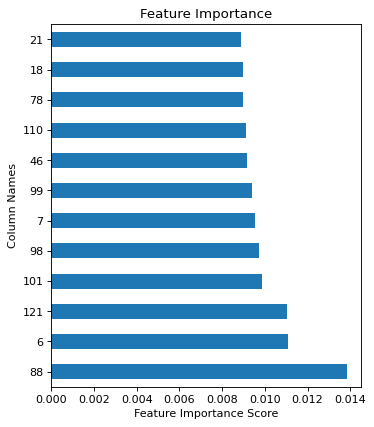

In [ ]:
from matplotlib.pyplot import figure

figure(num=None, figsize=(5,6), dpi=80, facecolor='w', edgecolor='k')

feat_importances = pd.Series(clf_important.feature_importances_).sort_values(ascending=False)
feat_importances.nlargest(12).plot(kind='barh')
plt.title("Feature Importance")
plt.xlabel("Feature Importance Score")
plt.ylabel("Column Names")
plt.show()

Now lets shift for deep learning approach CNN(convolutional neural network).

which generally outperforms machine learning model when we have enough data.

# Convolutional Neural Network (CNN)

In [ ]:
# convert the target variable into the CNN format
from keras.utils import np_utils
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)

In [ ]:
X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)
X_train.shape

(565, 313, 1)

In [ ]:
# Import libraries required for CNN
import keras
from keras.models import Sequential
from keras.layers import Convolution1D,MaxPooling1D,Dropout,Flatten,Dense,BatchNormalization,Conv1D,Activation
from keras.optimizers import RMSprop
from keras.losses import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator

### Model 1

#### Increasing the filter size from 32 to 1024 

In [ ]:
dropout_value = 0.25
model = Sequential()

model.add(Conv1D(32, 3, padding='same',input_shape=(X_train.shape[1],1)))  # X_train.shape[1] = No. of Columns
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(dropout_value))

model.add(Conv1D(64, 3, padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(dropout_value))

model.add(MaxPooling1D(pool_size=(4)))

model.add(Conv1D(128, 3, padding='same'))
model.add(Activation('relu'))
model.add(Dropout(dropout_value))
model.add(BatchNormalization())

model.add(Conv1D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(dropout_value))

model.add(MaxPooling1D(pool_size=(2)))

model.add(Conv1D(512, 3, padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(dropout_value))

model.add(Conv1D(1024, 3, padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(dropout_value))

model.add(MaxPooling1D(pool_size=(2)))
        
model.add(Flatten()) 

model.add(Dense(100))

model.add(Dense(19)) # Target class number
model.add(Activation('softmax'))
opt = keras.optimizers.SGD(lr=0.001, momentum=0.9, decay=0.0, nesterov=False)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 313, 32)           128       
_________________________________________________________________
activation (Activation)      (None, 313, 32)           0         
_________________________________________________________________
batch_normalization (BatchNo (None, 313, 32)           128       
_________________________________________________________________
dropout (Dropout)            (None, 313, 32)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 313, 64)           6208      
_________________________________________________________________
activation_1 (Activation)    (None, 313, 64)           0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 313, 64)           2

set the optimizer and loss function

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='Adam',metrics=['accuracy'])
epochs = 40
history = model.fit(X_train, y_train, batch_size=16, epochs = epochs, validation_data=(X_test, y_test))

Epoch 1/40
36/36 [==============================] - 14s 327ms/step - loss: 18.6588 - accuracy: 0.0845 - val_loss: 5.4006 - val_accuracy: 0.0500
Epoch 2/40
36/36 [==============================] - 11s 317ms/step - loss: 14.1093 - accuracy: 0.2619 - val_loss: 10.8892 - val_accuracy: 0.0500
Epoch 3/40
36/36 [==============================] - 12s 337ms/step - loss: 14.3452 - accuracy: 0.3744 - val_loss: 13.5615 - val_accuracy: 0.0700
Epoch 4/40
36/36 [==============================] - 12s 328ms/step - loss: 11.5825 - accuracy: 0.5072 - val_loss: 27.0754 - val_accuracy: 0.0800
Epoch 5/40
36/36 [==============================] - 12s 323ms/step - loss: 6.2548 - accuracy: 0.6319 - val_loss: 16.0890 - val_accuracy: 0.0800
Epoch 6/40
36/36 [==============================] - 11s 318ms/step - loss: 5.0848 - accuracy: 0.7260 - val_loss: 42.2303 - val_accuracy: 0.0600
Epoch 7/40
36/36 [==============================] - 12s 321ms/step - loss: 3.7916 - accuracy: 0.7244 - val_loss: 48.0951 - val_accura

## Accuracy, Loss Plots

In [ ]:
def plot_loss(history):
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Training for ' +str(epochs)+ ' epochs')
  plt.legend(['Training Loss', 'Validation Loss'], loc='best fit')
  plt.show()

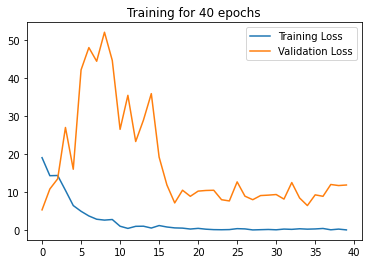

In [ ]:
plot_loss(history)

In [ ]:
#============accuracy vs epoch graph============#
def plot_accuracy(history):
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Training for ' +str(epochs)+ ' epochs')
  plt.legend(['Training accuracy', 'Validation accuracy'], loc='best fit')
  plt.show()


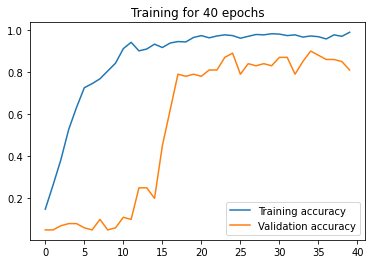

In [ ]:
plot_accuracy(history)

In [ ]:
#----------------------------CNN Evaluations------------------------------------------#
from sklearn.metrics import classification_report,accuracy_score

def model_classification_report(X_test,y_test ):
  pred_prob=model.predict(X_test)  # predict validation set and compare with actual class
  pred=np.argmax(pred_prob,axis=-1)
  print(classification_report(np.argmax(y_test,axis=1),pred))
  print('Accuracy on Validation Set',accuracy_score(pred,np.argmax(y_test,axis=1)))

model_classification_report(X_test,y_test )

              precision    recall  f1-score   support

           0       0.62      1.00      0.77         5
           1       0.25      0.60      0.35         5
           2       1.00      0.80      0.89         5
           3       1.00      1.00      1.00         5
           4       1.00      1.00      1.00         5
           5       0.71      1.00      0.83         5
           6       0.67      0.33      0.44         6
           7       1.00      0.83      0.91         6
           8       0.83      1.00      0.91         5
           9       1.00      0.20      0.33         5
          10       1.00      0.33      0.50         6
          11       1.00      0.40      0.57         5
          12       1.00      1.00      1.00         6
          13       0.62      1.00      0.77         5
          14       1.00      1.00      1.00         6
          15       1.00      1.00      1.00         5
          16       1.00      1.00      1.00         5
          17       1.00    

## Feature Extraction with CNN Dense Layers
 

In [ ]:
#=========================Here we have to use machine learning model. we extract feature from cnn layes ( first dense layer in cnn architecture
#of size 512 (each example make 512 feature vector) In this way we will get all feature vector).read any feature extraction paper using cnn for more info

def cnn_denselayer_features(layer_number):
  Layer = []
  for layer in model.layers:
      Layer.append(layer.name)
  output_layer = Layer[::-1][layer_number]
  return output_layer

layyr = cnn_denselayer_features(1)
print("layer name" ,layyr)

layer name dense_1


In [ ]:
#---------------Aplying SVM---------------------------------#

from keras.models import Model

model_feat = Model(inputs=model.input,outputs=model.get_layer(layyr).output)  #  make a model for feature extraction

feat_train = model_feat.predict(X_train)    # calculate feature vector of x_train ( model already learn a features from x_train)
print(feat_train.shape)

feat_val = model_feat.predict(X_test)         # based on learning from x_train. model predict x_val features
print(feat_val.shape)

(565, 19)
(100, 19)


In [ ]:
#================== SVM ===================#

from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

def run_all_classifiers(y_train,y_test, feat_train, feat_val):

  '''
  This function will run all the classifiers and prints eachh classifiers result

  Inputs: 
  1) y_train,y_test = labels of train & test data
  2) feat_train, feat_val = features extracted from CNN dense layers

  '''
  
  svm = SVC(kernel='rbf',gamma='auto',C=1.0,degree=3,tol=0.001)

  svm.fit(feat_train,np.argmax(y_train,axis=1))      # fit svm model
  print("#================== SVM ===================#")
  print('\nfitting done !!!')

  #---------------Validation Score---------------#

  print("\nValidation SVC Accuracy",svm.score(feat_val,np.argmax(y_test,axis=1)))
  pred=svm.predict(feat_val)

  # print(classification_report(np.argmax(y_test,axis=1),pred))
  print("\nSVC AUC_ROC:",multiclass_roc_auc_score(np.argmax(y_test,axis=1),pred))

  #================== Gradient Boost ===================#
  gb = GradientBoostingClassifier(learning_rate=0.001, n_estimators=100, max_depth=8)
  gb.fit(feat_train,np.argmax(y_train,axis=1))
  print("#\n================== Gradient Boost ===================#")

  print('\nfitting done !!!')

  #----Validation Score---------------#

  print("\nValidation Xgboost Accuracy",gb.score(feat_val,np.argmax(y_test,axis=1)))
  pred=gb.predict(feat_val)
  # print(classification_report(np.argmax(y_test,axis=1),pred))
  print("\nXgboost AUC_ROC:",multiclass_roc_auc_score(np.argmax(y_test,axis=1),pred))


  #==================logistics regression===================#
  lr = LogisticRegression() #tol=0.0001,C=1.0
  lr.fit(feat_train,np.argmax(y_train,axis=1))
  print("\n#==================logistics regression===================#")
  print('\nfitting done !!!')

  #---------------Validation Score---------------#

  print("\nValidation Logistic regression Accuracy",lr.score(feat_val,np.argmax(y_test,axis=1)))
  pred=lr.predict(feat_val)
  # print(classification_report(np.argmax(y_test,axis=1),pred))
  print("\nLogistic regression AUC_ROC:",multiclass_roc_auc_score(np.argmax(y_test,axis=1),pred))


  #================== Random forest ===================#
  RF = RandomForestClassifier()
  RF.fit(feat_train,np.argmax(y_train,axis=1))
  print("\n#================== Random forest ===================#")
  print('fitting done !!!')

  #----Validation Score---------------#

  print("\nValidation RandomForest Accuracy",RF.score(feat_val,np.argmax(y_test,axis=1)))
  pred=RF.predict(feat_val)
  print("\nRandom Forest AUC_ROC :",multiclass_roc_auc_score(np.argmax(y_test,axis=1),pred))


  #================== knn ===================#
  knn = KNeighborsClassifier(n_neighbors = 1)
  knn.fit(feat_train,np.argmax(y_train,axis=1))
  print("\n#================== knn ===================#")
  print('\nfitting done !!!')

  #----------Validation Score---------------#

  print("\nValidation KNN Accuracy",knn.score(feat_val,np.argmax(y_test,axis=1)))
  pred=knn.predict(feat_val)
  print("\nKNN AUC_ROC:",multiclass_roc_auc_score(np.argmax(y_test,axis=1),pred))

  #================== Naive bayes ===================#
  gnb = GaussianNB()
  gnb.fit(feat_train,np.argmax(y_train,axis=1))
  print("\n#================== Naive bayes ===================#")
  print('\nfitting done !!!')

  #----------Validation Score---------------#

  print("\nValidation Gaussian bayes Accuracy",gnb.score(feat_val,np.argmax(y_test,axis=1)))
  pred=gnb.predict(feat_val)
  print("\nNaive bayes AUC_ROC:",multiclass_roc_auc_score(np.argmax(y_test,axis=1),pred))



## Plot AUC ROC for CNN extrcted dense layer model

In [ ]:
from sklearn.metrics import roc_curve, auc

def plot_auc2(model):

  model.fit(feat_train, np.argmax(y_train,axis=1))

  y_scores = model.predict_proba(feat_val)

  y_onehot = y_test

  fig = go.Figure()
  fig.add_shape(
      type='line', line=dict(dash='dash'),
      x0=0, x1=1, y0=0, y1=1
  )
  y_onehot = pd.DataFrame(y_onehot)
  for i in range(y_scores.shape[1]):
      y_true = y_onehot.iloc[:, i]
      y_score = y_scores[:, i]

      fpr, tpr, _ = roc_curve(y_true, y_score)
      auc_score = roc_auc_score(y_true, y_score)

      name = f"{y_onehot.columns[i]} (AUC={auc_score:.2f})"
      fig.add_trace(go.Scatter(x=fpr, y=tpr, name=name, mode='lines'))

  fig.update_layout(
      # title = 'Multiclasss AUC',
      xaxis_title='False Positive Rate',
      yaxis_title='True Positive Rate',
      yaxis=dict(scaleanchor="x", scaleratio=1),
      xaxis=dict(constrain='domain'),
      width=700, height=500
  )
  fig.show()

In [ ]:
# call run_all_classifiers function to see the results

run_all_classifiers(y_train,y_test, feat_train, feat_val)

#================== SVM ===================#

fitting done !!!

Validation SVC Accuracy 0.05

SVC AUC_ROC: 0.5
#
================== Gradient Boost ===================#

fitting done !!!

Validation Xgboost Accuracy 0.81

Xgboost AUC_ROC: 0.9043741773246105

#==================logistics regression===================#

fitting done !!!

Validation Logistic regression Accuracy 0.86

Logistic regression AUC_ROC: 0.9276890434372607

#================== Random forest ===================#
fitting done !!!

Validation RandomForest Accuracy 0.86

Random Forest AUC_ROC : 0.9285603426258816

#================== knn ===================#

fitting done !!!

Validation KNN Accuracy 0.89

KNN AUC_ROC: 0.9434352959666804

#================== Naive bayes ===================#

fitting done !!!

Validation Gaussian bayes Accuracy 0.76

Naive bayes AUC_ROC: 0.8766645056089272


In [ ]:
model = RandomForestClassifier()
plot_auc2(model)

### Model 2)

#### with decreasing filters from 1024 to 32

In [ ]:
dropout_value = 0.2

model = Sequential()

model.add(Conv1D(1024, 3, padding='same',input_shape=(X_train.shape[1],1)))  # X_train.shape[1] = No. of Columns
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(dropout_value))

model.add(MaxPooling1D(pool_size=(2)))

model.add(Conv1D(512, 3, padding='same'))
model.add(Activation('relu'))
model.add(Dropout(dropout_value))
model.add(BatchNormalization())

model.add(MaxPooling1D(pool_size=(2)))

model.add(Conv1D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(dropout_value))

model.add(MaxPooling1D(pool_size=(2)))

model.add(Conv1D(128, 3, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(dropout_value))

model.add(MaxPooling1D(pool_size=(2)))

model.add(Conv1D(64, 3, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(dropout_value))

model.add(MaxPooling1D(pool_size=(2)))

model.add(Conv1D(32, 3, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(dropout_value))
        
model.add(Flatten()) 

model.add(Dense(100))
model.add(Dense(19)) # Target class number
model.add(Activation('softmax'))
# opt = keras.optimizers.SGD(lr=0.0001, momentum=0.9, decay=0.0, nesterov=False)
opt = keras.optimizers.Adam(lr=0.001)
# opt = keras.optimizers.rmsprop(lr=0.00001, decay=1e-6)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, 313, 1024)         4096      
_________________________________________________________________
activation_7 (Activation)    (None, 313, 1024)         0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 313, 1024)         4096      
_________________________________________________________________
dropout_6 (Dropout)          (None, 313, 1024)         0         
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 156, 1024)         0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 156, 512)          1573376   
_________________________________________________________________
activation_8 (Activation)    (None, 156, 512)         

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer= 'Adam',metrics=['accuracy'])
model_history=model.fit(X_train, y_train, batch_size=32, epochs = 40, validation_data=(X_test, y_test))

Epoch 1/40
18/18 [==============================] - 34s 2s/step - loss: 3.3291 - accuracy: 0.0858 - val_loss: 2.8651 - val_accuracy: 0.1200
Epoch 2/40
18/18 [==============================] - 32s 2s/step - loss: 2.6329 - accuracy: 0.2316 - val_loss: 2.9501 - val_accuracy: 0.0800
Epoch 3/40
18/18 [==============================] - 31s 2s/step - loss: 2.4715 - accuracy: 0.2514 - val_loss: 3.0576 - val_accuracy: 0.1000
Epoch 4/40
18/18 [==============================] - 31s 2s/step - loss: 2.2058 - accuracy: 0.3315 - val_loss: 3.4924 - val_accuracy: 0.0500
Epoch 5/40
18/18 [==============================] - 32s 2s/step - loss: 2.1377 - accuracy: 0.3187 - val_loss: 3.8241 - val_accuracy: 0.0500
Epoch 6/40
18/18 [==============================] - 33s 2s/step - loss: 1.7290 - accuracy: 0.4930 - val_loss: 4.1083 - val_accuracy: 0.0500
Epoch 7/40
18/18 [==============================] - 32s 2s/step - loss: 1.6129 - accuracy: 0.4791 - val_loss: 4.2537 - val_accuracy: 0.0500
Epoch 8/40
18/18 [==

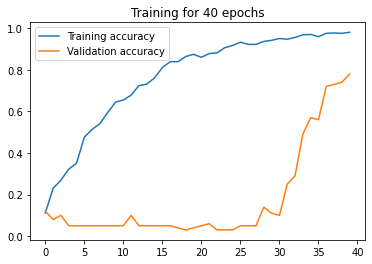

In [ ]:
plot_accuracy(model_history)

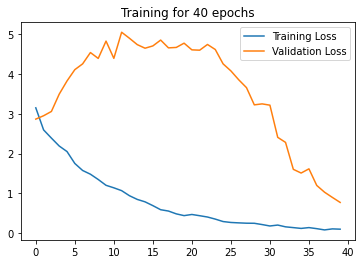

In [ ]:
plot_loss(model_history)

In [ ]:
layyr = cnn_denselayer_features(2)
print(layyr)

dense_2


In [ ]:
model_feat = Model(inputs=model.input,outputs=model.get_layer(layyr).output)  #  make a model for feature extraction

feat_train = model_feat.predict(X_train)    # calculate feature vector of x_train ( model already learn a features from x_train)
print(feat_train.shape)

feat_val = model_feat.predict(X_test)         # based on learning from x_train. model predict x_val features
print(feat_val.shape)

(565, 100)
(100, 100)


In [ ]:
# call run_all_classifiers function to see the results

run_all_classifiers(y_train,y_test, feat_train, feat_val)

#================== SVM ===================#

fitting done !!!

Validation SVC Accuracy 0.89

SVC AUC_ROC: 0.9425610498811418
#
================== Gradient Boost ===================#

fitting done !!!

Validation Xgboost Accuracy 0.45

Xgboost AUC_ROC: 0.7128081963026268

#==================logistics regression===================#

fitting done !!!

Validation Logistic regression Accuracy 0.88

Logistic regression AUC_ROC: 0.9370208836761557

#================== Random forest ===================#
fitting done !!!

Validation RandomForest Accuracy 0.88

Random Forest AUC_ROC : 0.9378980766586119

#================== knn ===================#

fitting done !!!

Validation KNN Accuracy 0.86

KNN AUC_ROC: 0.9276978841280132

#================== Naive bayes ===================#

fitting done !!!

Validation Gaussian bayes Accuracy 0.61

Naive bayes AUC_ROC: 0.7961965383784209


plt the AUC ROC for the CNN dense extracted features model

In [ ]:
model = SVC(kernel='rbf',gamma='auto',C=1.0,degree=3,tol=0.001,probability=True)
plot_auc2(model)

### Model 3

#### lets simplify some things and build a smaller precise model

In [ ]:
#----------- Model Archirtechture-----------------------------------#

model = Sequential()
dropout_value = 0.4

model.add(Conv1D(8, 3, padding='same',input_shape=(X_train.shape[1],1)))  # X_train.shape[1] = No. of Columns
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(dropout_value))

model.add(Conv1D(16, 3, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(dropout_value))

model.add(Conv1D(24, 3, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(dropout_value))
model.add(Flatten()) 

model.add(Dense(500))

model.add(Dense(19)) # Target class number
model.add(Activation('softmax'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_12 (Conv1D)           (None, 313, 8)            32        
_________________________________________________________________
activation_14 (Activation)   (None, 313, 8)            0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 313, 8)            32        
_________________________________________________________________
dropout_12 (Dropout)         (None, 313, 8)            0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 313, 16)           400       
_________________________________________________________________
batch_normalization_13 (Batc (None, 313, 16)           64        
_________________________________________________________________
activation_15 (Activation)   (None, 313, 16)          

In [ ]:
#============ Compile the Model ============#

epochs = 40

model.compile(loss='categorical_crossentropy', optimizer='RMSPROP', metrics=['accuracy'])
model_history=model.fit(X_train, y_train, batch_size= 50, epochs = epochs, validation_data = (X_test, y_test))

Epoch 1/40
12/12 [==============================] - 3s 112ms/step - loss: 28.0838 - accuracy: 0.1064 - val_loss: 5.3209 - val_accuracy: 0.1900
Epoch 2/40
12/12 [==============================] - 1s 92ms/step - loss: 20.7535 - accuracy: 0.2326 - val_loss: 3.5095 - val_accuracy: 0.2100
Epoch 3/40
12/12 [==============================] - 2s 130ms/step - loss: 8.1310 - accuracy: 0.4222 - val_loss: 2.3769 - val_accuracy: 0.3200
Epoch 4/40
12/12 [==============================] - 1s 94ms/step - loss: 4.3717 - accuracy: 0.5571 - val_loss: 2.8309 - val_accuracy: 0.5300
Epoch 5/40
12/12 [==============================] - 1s 93ms/step - loss: 5.2934 - accuracy: 0.6034 - val_loss: 1.8883 - val_accuracy: 0.6400
Epoch 6/40
12/12 [==============================] - 1s 92ms/step - loss: 2.3901 - accuracy: 0.7614 - val_loss: 2.0946 - val_accuracy: 0.4200
Epoch 7/40
12/12 [==============================] - 1s 93ms/step - loss: 1.2245 - accuracy: 0.8298 - val_loss: 2.0558 - val_accuracy: 0.5000
Epoch 8/4

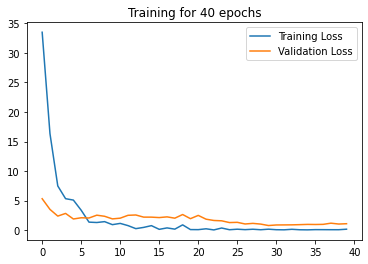

In [ ]:
plot_loss(model_history)


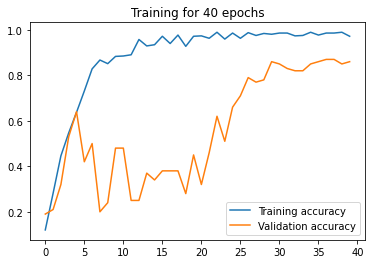

In [ ]:
#============accuracy vs epoch graph============#

plot_accuracy(model_history)

In [ ]:
#----------------------------CNN Evaluations------------------------------------------#

model_classification_report(X_test,y_test )

              precision    recall  f1-score   support

           0       0.83      1.00      0.91         5
           1       0.17      0.20      0.18         5
           2       1.00      1.00      1.00         5
           3       1.00      1.00      1.00         5
           4       0.62      1.00      0.77         5
           5       0.83      1.00      0.91         5
           6       0.75      0.50      0.60         6
           7       1.00      0.83      0.91         6
           8       0.83      1.00      0.91         5
           9       1.00      0.40      0.57         5
          10       0.60      0.50      0.55         6
          11       1.00      1.00      1.00         5
          12       1.00      1.00      1.00         6
          13       1.00      1.00      1.00         5
          14       1.00      1.00      1.00         6
          15       1.00      1.00      1.00         5
          16       1.00      1.00      1.00         5
          17       1.00    

In [ ]:
#========= Here we will use machine learning model. we extract feature from cnn layes ( first dense layer in cnn architecture
#of size 512 (each example make 512 feature vector) In this way we will get all feature vector).read any feature extraction paper using cnn for more info

layyr = cnn_denselayer_features(3)

print("we are extracting information from layer", layyr)

we are extracting information from layer flatten_2


In [ ]:
#================== Feature extraction ===================#

from keras.models import Model

model_feat = Model(inputs=model.input,outputs=model.get_layer(layyr).output)  #  make a model for feature extraction

feat_train = model_feat.predict(X_train)    # calculate feature vector of x_train ( model already learn a features from x_train)
print(feat_train.shape)

feat_val = model_feat.predict(X_test)         # based on learning from x_train. model predict x_val features
print(feat_val.shape)

(565, 7512)
(100, 7512)


In [ ]:
#================== Model Evaluation ===================#

run_all_classifiers(y_train,y_test, feat_train, feat_val)

#================== SVM ===================#

fitting done !!!

Validation SVC Accuracy 0.42

SVC AUC_ROC: 0.7049861495844876
#
================== Gradient Boost ===================#

fitting done !!!

Validation Xgboost Accuracy 0.67

Xgboost AUC_ROC: 0.8267971159702168

#==================logistics regression===================#

fitting done !!!

Validation Logistic regression Accuracy 0.88

Logistic regression AUC_ROC: 0.939646568829689

#================== Random forest ===================#
fitting done !!!

Validation RandomForest Accuracy 0.9

Random Forest AUC_ROC : 0.950735741930414

#================== knn ===================#

fitting done !!!

Validation KNN Accuracy 0.88

KNN AUC_ROC: 0.9387752696410679

#================== Naive bayes ===================#

fitting done !!!

Validation Gaussian bayes Accuracy 0.78

Naive bayes AUC_ROC: 0.888624977898273


In [ ]:
model = RandomForestClassifier()
plot_auc2(model)

## Data Augmentation with supplemental spectrogram data

In [ ]:
# Import libraries required for CNN
import keras
from keras.models import Sequential
from keras.layers import Convolution1D,MaxPooling1D,Dropout,Flatten,Dense,BatchNormalization,Conv1D,Activation
from keras.optimizers import RMSprop
from keras.losses import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
path = "/content/drive/My Drive/Competitions/Kaggle_MLSP_Bird_Classification/supplemental_data"

import os
os.chdir(path)

In [ ]:
os.chdir('filtered_spectrograms')

In [ ]:
#============================ concate recording id, label & fold data together ===========================#

data = pd.concat([rec_id_2_filename,fold_name['fold'],labels['labels']],axis=1)
data

,rec_id,filename,fold,labels
0,0,PC1_20090513_050000_0010,1,?
1,1,PC1_20090513_070000_0010,1,?
2,2,PC1_20090606_050012_0010,0,11
3,3,PC1_20090606_070012_0010,0,NaN
4,4,PC1_20090705_050000_0010,1,?
...,...,...,...,...
640,640,PC18_20100513_043000_0750,0,8
641,641,PC18_20100705_050000_0040,0,4
642,642,PC18_20100705_070000_0040,0,4
643,643,PC18_20100804_050020_0040,1,?


In [ ]:
#============================ seperate out two folds ===========================#

train = data[data['fold']==0]

test = data[data['fold']==1]

In [ ]:
train.shape

(322, 4)

In [ ]:
train = train.fillna(19)

In [ ]:
train.head()

,rec_id,filename,fold,labels
2,2,PC1_20090606_050012_0010,0,11
3,3,PC1_20090606_070012_0010,0,19
5,5,PC1_20090705_070000_0010,0,10
8,8,PC1_20100513_043000_0010,0,19
9,9,PC1_20100513_043000_0720,0,19


In [ ]:
from tqdm import tqdm
from keras.preprocessing import image

list = train.index.tolist()
# We have grayscale images, so while loading the images we will keep grayscale=True, if you have RGB images, you should set grayscale as False
train_image = []
for i in tqdm((list)):
    img = image.load_img(train['filename'][i]+'.bmp', target_size=(224,224,3), grayscale=False)
    img = image.img_to_array(img)
    img = img/255
    train_image.append(img)

X = np.array(train_image)

100%|██████████| 322/322 [01:25<00:00,  3.78it/s]


In [ ]:
X.shape

(322, 224, 224, 3)

In [ ]:
from keras.utils import to_categorical
y=train['labels'].values
y = to_categorical(y)

In [ ]:
y.shape

(322, 20)

In [ ]:
# import tensorflow as tf
# datagen = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=10, 
#                                                           width_shift_range=0.1, 
#                                                           shear_range=10,
#                                                           height_shift_range=0.1,
#                                                           zoom_range=0.2)
# datagen.fit(X)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,stratify=y , test_size=0.15,random_state=42) 


In [ ]:
#----------- Model Archirtechture-----------------------------------#
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Sequential
from keras.layers import GaussianNoise

model = Sequential()
dropout_value = 0.2

model.add(Conv2D(8, kernel_size=(7, 7),activation='relu',input_shape=(224,224,3)))
model.add(BatchNormalization())
model.add(Dropout(dropout_value))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(12, (7, 7), activation='relu'))
model.add(GaussianNoise(0.1))
model.add(BatchNormalization())
model.add(Dropout(dropout_value))

model.add(Conv2D(16, (7, 7), activation='relu'))
model.add(GaussianNoise(0.1))
model.add(BatchNormalization())
model.add(Dropout(dropout_value))

model.add(Conv2D(24, (7, 7), activation='relu'))
model.add(GaussianNoise(0.1))
model.add(BatchNormalization())
model.add(Dropout(dropout_value))

model.add(Flatten())

model.add(Dense(500, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(20, activation='softmax'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 218, 218, 8)       1184      
_________________________________________________________________
batch_normalization_15 (Batc (None, 218, 218, 8)       32        
_________________________________________________________________
dropout_15 (Dropout)         (None, 218, 218, 8)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 109, 109, 8)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 103, 103, 12)      4716      
_________________________________________________________________
gaussian_noise (GaussianNois (None, 103, 103, 12)      0         
_________________________________________________________________
batch_normalization_16 (Batc (None, 103, 103, 12)     

In [ ]:
# performing data argumentation by training image generator
# dataAugmentaion = ImageDataGenerator(rotation_range = 30, 
#                                      zoom_range = 0.20, 
#                                       fill_mode = "nearest", 
#                                      shear_range = 0.20, 
#                                      horizontal_flip = True, 
#                                       width_shift_range = 0.1, 
#                                      height_shift_range = 0.1)
import random

def add_noise(img):
    '''Add random noise to an image'''
    VARIABILITY = 50
    deviation = VARIABILITY*random.random()
    noise = np.random.normal(0, deviation, img.shape)
    img += noise
    np.clip(img, 0., 255.)
    return img

dataAugmentaion = ImageDataGenerator(featurewise_center=True,
    samplewise_center=True,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=True,
    zca_epsilon=1e-06,
    rotation_range=0.02,
    width_shift_range=0.02,
    height_shift_range=0.02,
    shear_range=0.02,
    zoom_range=0.02,
    channel_shift_range=0.02,
    fill_mode="nearest")
    # cval=0.0,
    # brightness_range=(-1,1),
    # ,preprocessing_function=add_noise)

model.compile(loss='categorical_crossentropy', optimizer='ADAM',metrics=['accuracy'])

# training the model
model.fit_generator(dataAugmentaion.flow(X_train, y_train, batch_size = 32),
                   validation_data = (X_test, y_test), 
                    steps_per_epoch = len(X_train) // 32,epochs = 30)
                    

Epoch 1/30
8/8 [==============================] - 51s 6s/step - loss: 0.0757 - accuracy: 0.9785 - val_loss: 2.3243 - val_accuracy: 0.4694
Epoch 2/30
8/8 [==============================] - 47s 6s/step - loss: 0.1539 - accuracy: 0.9804 - val_loss: 3.4398 - val_accuracy: 0.4490
Epoch 3/30
8/8 [==============================] - 47s 6s/step - loss: 0.5528 - accuracy: 0.9173 - val_loss: 3.3584 - val_accuracy: 0.4490
Epoch 4/30
8/8 [==============================] - 47s 6s/step - loss: 0.2426 - accuracy: 0.9438 - val_loss: 3.9698 - val_accuracy: 0.4490
Epoch 5/30
8/8 [==============================] - 47s 6s/step - loss: 0.2632 - accuracy: 0.9401 - val_loss: 4.8599 - val_accuracy: 0.4490
Epoch 6/30
8/8 [==============================] - 47s 6s/step - loss: 0.2189 - accuracy: 0.9277 - val_loss: 5.7418 - val_accuracy: 0.4490
Epoch 7/30
8/8 [==============================] - 47s 6s/step - loss: 0.0826 - accuracy: 0.9679 - val_loss: 6.2153 - val_accuracy: 0.4490
Epoch 8/30
8/8 [==================